In [125]:
# ! pip install ipympl
#!pip install scikit-learn
#! pip install seaborn

In [126]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 데이터 로딩 및 전처리

In [127]:
# 예시 경로, 실제 경로로 수정 필요

# 게임에 참가한 사람들의 고유 정보
participants = pd.read_csv("data/top1000/participants.csv")
# 시간 흐름에 따라 변화하는 실시간 스탯 (골드, 딜량 등) 
participants_frames = pd.read_csv("data/top1000/participant_frames.csv")
# 게임 단위의 결과 (승패 등)
matches = pd.read_csv("data/top1000/matches.csv")
# 킬 이벤트 정보 (누가 누구를 죽였는지)
champ_kill = pd.read_csv('data/top1000/events__CHAMPION_KILL.csv')

In [128]:
champ_kill.head()

,bounty,frame_timestamp,game_id,kill_streak_length,killer_id,position_x,position_y,shutdown_bounty,timestamp,type,victim_id
0,300.0,180020,7586549521,0.0,10.0,12555.0,1765.0,0.0,150975,CHAMPION_KILL,5.0
1,300.0,180020,7586549521,1.0,10.0,12244.0,2880.0,0.0,154282,CHAMPION_KILL,4.0
2,300.0,240021,7586549521,0.0,8.0,7875.0,6366.0,0.0,182192,CHAMPION_KILL,3.0
3,300.0,300047,7586549521,1.0,8.0,9952.0,5800.0,0.0,249951,CHAMPION_KILL,2.0
4,220.0,300047,7586549521,2.0,10.0,10381.0,5133.0,0.0,253357,CHAMPION_KILL,5.0


In [129]:
# 가장 마지막 프레임만 사용 (게임 종료 시점 상태)
# 게임 종료 시점 기준으로 정보 하나로 묶기
latest_frames = participants_frames.sort_values("frame_timestamp").drop_duplicates(
    subset=["game_id", "participant_id"], keep='last'
)

merged_df = pd.merge(participants, latest_frames, on=["game_id", "participant_id"], how="left")

## 2. KDA 및 주요 파생 지표 생성

### KDA 계산

컬럼 | 의미
---- | ----
kills | 해당 경기에서 몇 번 킬 했는가
deaths | 몇 번 죽었는가
assists | 어시스트 수
KDA | (킬 + 어시스트) / 데스 (생존 기반 전투 영향력)

In [130]:
# kills 수 계산 (킬한 사람 기준)
kills = champ_kill.groupby(["game_id", "killer_id"]).size().reset_index(name="kills")
kills.rename(columns={"killer_id": "participant_id"}, inplace=True)

In [131]:
# deaths 수 계산 (죽은 사람 기준)
deaths = champ_kill.groupby(["game_id", "victim_id"]).size().reset_index(name="deaths")
deaths.rename(columns={"victim_id": "participant_id"}, inplace=True)

In [132]:
# assists 수 계산
assist_df = pd.read_csv("data/top1000/event_assists.csv")

# 게임 ID + 어시스트 참가자 ID로 그룹화
assists = assist_df.groupby(["game_id", "participant_id"]).size().reset_index(name="assists")


In [133]:
# KDA 구하기

# 기본 participant list (merged_df)에서 가져오자
kda_base = merged_df[["game_id", "participant_id", "puuid"]].drop_duplicates()

# 병합
kda_df = (
    kda_base
    .merge(kills, on=["game_id", "participant_id"], how="left")
    .merge(deaths, on=["game_id", "participant_id"], how="left")
)

# 어시스트 컬럼 있으면 병합
if 'assists' in locals():
    kda_df = kda_df.merge(assists, on=["game_id", "participant_id"], how="left")

# 결측값 0으로 채우기
kda_df[["kills", "deaths", "assists"]] = kda_df[["kills", "deaths", "assists"]].fillna(0).astype(int)

# KDA 계산
# 분모가 0이 되면 오류가 나기 때문에, 완벽 생존은 1로 나눈 값을 최대치로 보정
kda_df["KDA"] = (kda_df["kills"] + kda_df["assists"]) / kda_df["deaths"].replace(0, 1)


In [134]:
# merged_df에 병합

merged_df = pd.merge(merged_df, kda_df[["game_id", "participant_id", "kills", "deaths", "assists", "KDA"]],
                     on=["game_id", "participant_id"], how="left")
merged_df.head()

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,totalDamageDone,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken,kills,deaths,assists,KDA
0,7586549521,1,T2coi9U5HI63yttsRxRgUeQ2xLzedwMv0LWMV_Xtp812gj...,1956361,3780,0,4,18,236,227461,...,221039,38637,35625,26709,13168,3156,13,3,19,10.666667
1,7586549521,2,VzxkuEt2Ay_6P_1wY1FajjdMW8ty20cPLb0jmwqAAjA9Ns...,1956361,1597,0,142,17,22,171344,...,251617,26859,44796,65212,2829,2577,12,10,14,2.600000
2,7586549521,3,-jMFYAy4ogcmItoiwYmQX7tG2fB59CvKQieQwZqYvcLw1x...,1956361,2454,0,8,17,232,259989,...,206296,37478,31216,7563,1790,3254,4,11,19,2.090909
3,7586549521,4,CDtqv-NZS5cmtQI0bsfbxBhq29QlqmwX_YwgG5oW3PkhMm...,1956361,1339,0,16,18,199,130050,...,217726,47278,33657,9483,2649,782,16,11,15,2.818182
4,7586549521,5,72aXoGzHe_SjiP1hNKnMXyx_UYND4_HE2j1Awp9E3l6pge...,1956361,1189,50,0,14,15,226379,...,17701,12926,36143,3208,2008,2392,2,15,23,1.666667


## 유사도 기반 파생 지표 생성 (예시: 시야 점수, 미니언 수, 골드 등)

### 성장 및 경제 지표        

| 지표 | 의미 | 해석 |  
| ---- | ---- | ---- |   
| CS/Min | 분당 미니언 수급량 | 파밍 능력 |     
| Gold/Min | 분당 골드 | 성장 속도 |        
| XP/Min | 분당 경험치 | 레벨 성장 속도 |       




In [135]:
# 성장 및 경제 지표

# 분당 라인 몬스터 
merged_df['lane_cs_per_min'] = merged_df['minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# 분당 정글 몬스터
merged_df['jungle_cs_per_min'] = merged_df['jungle_minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# # CS (미니언 + 정글)
# merged_df["cs"] = merged_df["minions_killed"] + merged_df["jungle_minions_killed"]

# # 분당 CS
# merged_df["cs_per_min"] = merged_df["cs"] / (merged_df["frame_timestamp"] / 60000)

# jungle 성향 분석
merged_df['jungle_ratio'] = merged_df['jungle_minions_killed'] / (merged_df['jungle_minions_killed'] + merged_df['minions_killed'])

# 분당 골드
merged_df["gold_per_min"] = merged_df["total_gold"] / (merged_df["frame_timestamp"] / 60000)

# 분당 경험치
merged_df["xp_per_min"] = merged_df["xp"] / (merged_df["frame_timestamp"] / 60000)

### 전투 능력 지표

지표 | 의미 | 해석
---- | ---- | ----
Damage/Min | 분당 딜량 | 전투 기여도
Damage Taken/Min | 분당 받은 피해 | 탱킹 능력 또는 위험 노출
KA/Min | 분당 킬 관여 수 | 싸움 참여율 (적극적인지 여부)
Damage Efficiency | 피해 교환 비율 | 딜 효율 (딜을 얼마나 잘 넣고 덜 맞았는지)

In [136]:
# 전투력 관련 지표
# 분당 피해량
merged_df["damage_per_min"] = merged_df["totalDamageDoneToChampions"] / (merged_df["frame_timestamp"] / 60000)

# 분당 받은 피해량
merged_df["damage_taken_per_min"] = merged_df["totalDamageTaken"] / (merged_df["frame_timestamp"] / 60000)

# 분당 킬 관여율 (K+A)/시간
merged_df["ka_per_min"] = (merged_df["kills"] + merged_df["assists"]) / (merged_df["frame_timestamp"] / 60000)

# 피해 교환 효율 (딜량 / 받은 피해량)
merged_df["damage_efficiency"] = merged_df["totalDamageDoneToChampions"] / merged_df["totalDamageTaken"].replace(0, 1)


### 생존력 지표

지표 | 의미 | 해석
---- | ---- | ----
survivability | 생존률 | 
healthregen_per_min | 분당 체력 재생 | 


In [137]:
# 생존력 지표
# 생존률 (1 - 데스 / 평균 생존시간) → 데스 적을수록 높음
merged_df["survivability"] = 1 / merged_df["deaths"].replace(0, 1)

# 1. healthregen의 총합을 참가자별로 groupby
agg_df = participants_frames.groupby(['game_id', 'participant_id']).agg({
    'healthregen': 'sum',
    'frame_timestamp': 'max'  # 해당 플레이어의 게임 시간 (ms)
}).reset_index()

# 2. 게임 시간(ms)를 분 단위로 변환
agg_df['game_time_min'] = agg_df['frame_timestamp'] / 60000

# 3. 분당 체력 재생량 계산
agg_df['healthregen_per_min'] = agg_df['healthregen'] / agg_df['game_time_min']

# 4. merged_df에 병합 (game_id + participant_id 기준)
merged_df = merged_df.merge(
    agg_df[['game_id', 'participant_id', 'healthregen_per_min']],
    on=['game_id', 'participant_id'],
    how='left'
)

# # 분당 체력 재생
# merged_df["healthregen_per_min"] = merged_df["healthregen"] / (merged_df["frame_timestamp"] / 60000)


### 시야 장악 지표

지표 | 의미 | 해석
---- | ---- | ----
Wards Placed/Min | 분당 설치 | 시야 제공 적극성
Wards Killed/Min | 분당 제거 | 상대 시야 차단 능력
Vision Score Est. | 설치+제거 총합 | 시야 장악 종합 평가 (approx.)

In [138]:
# 포지션 제어 / 시야 장악 지표
wards_placed = pd.read_csv("data/top1000/events__WARD_PLACED.csv")
wards_killed = pd.read_csv("data/top1000/events__WARD_KILL.csv")

## 와드 설치 수
ward_placed_count = (
    wards_placed
    .groupby(["game_id", "creator_id"])
    .size()
    .reset_index(name="wards_placed")
    .rename(columns={"creator_id": "participant_id"})
)

## 와드 제거 수
ward_kill_count = (
    wards_killed
    .groupby(["game_id", "killer_id"])
    .size()
    .reset_index(name="wards_killed")
    .rename(columns={"killer_id": "participant_id"})
)

## merged_df에 와드 수 붙이기
merged_df = (
    merged_df
    .merge(ward_placed_count, on=["game_id", "participant_id"], how="left")
    .merge(ward_kill_count, on=["game_id", "participant_id"], how="left")
)

# 결측치는 0으로 처리
merged_df[["wards_placed", "wards_killed"]] = merged_df[["wards_placed", "wards_killed"]].fillna(0).astype(int)

## 시야 제어 파생 지표 추가
# 분당 와드 설치
merged_df["wards_placed_per_min"] = merged_df["wards_placed"] / (merged_df["frame_timestamp"] / 60000)

# 분당 와드 제거
merged_df["wards_killed_per_min"] = merged_df["wards_killed"] / (merged_df["frame_timestamp"] / 60000)

# 종합 시야 지표 (설치 + 제거)
merged_df["vision_score_est"] = merged_df["wards_placed"] + merged_df["wards_killed"]


### 종합 능력치 지표
기본 아이템 + 능력치 요약

In [139]:
# 아이템/스탯 관련 종합 능력치
# 전체 공격 스탯
merged_df["offensive_score"] = merged_df["attackdamage"] + merged_df["attackspeed"]

# 전체 방어 스탯
merged_df["defensive_score"] = merged_df["armor"] + merged_df["magicresist"]

# 전체 마법 능력치
merged_df["magic_score"] = merged_df["abilitypower"] + merged_df["magicpen"] + merged_df["magicpenpercent"]


생존 또는 스킬 활용 능력

In [140]:
# 기타 유틸성 스탯
# 만능 흡혈 + 물리 흡혈 + 주문 흡혈
merged_df["total_vamp"] = merged_df[["omnivamp", "physicalvamp", "spellvamp"]].sum(axis=1)

# 스킬 쿨다운 영향력
merged_df["haste_score"] = merged_df["cooldownreduction"] + merged_df["abilityhaste"]


## 3. 상위 1000명 필터링 및 일반 유저 선택

In [141]:
# Top 1000 유저 필터링
top1000_puuids = merged_df.sort_values("KDA", ascending=False)["puuid"].unique()[:1000]
merged_df["is_top1000"] = merged_df["puuid"].isin(top1000_puuids)
merged_df


,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score,is_top1000
0,7586549521,1,T2coi9U5HI63yttsRxRgUeQ2xLzedwMv0LWMV_Xtp812gj...,1956361,3780,0,4,18,236,227461,...,6,0.276023,0.184015,15,541,293,0,0,0,True
1,7586549521,2,VzxkuEt2Ay_6P_1wY1FajjdMW8ty20cPLb0jmwqAAjA9Ns...,1956361,1597,0,142,17,22,171344,...,6,0.337361,0.184015,17,478,195,0,0,0,False
2,7586549521,3,-jMFYAy4ogcmItoiwYmQX7tG2fB59CvKQieQwZqYvcLw1x...,1956361,2454,0,8,17,232,259989,...,5,0.306692,0.153346,15,383,203,344,0,0,True
3,7586549521,4,CDtqv-NZS5cmtQI0bsfbxBhq29QlqmwX_YwgG5oW3PkhMm...,1956361,1339,0,16,18,199,130050,...,4,0.214684,0.122677,11,476,175,414,0,0,False
4,7586549521,5,72aXoGzHe_SjiP1hNKnMXyx_UYND4_HE2j1Awp9E3l6pge...,1956361,1189,50,0,14,15,226379,...,6,1.717474,0.184015,62,222,269,30,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8855,7587349701,6,wh2vaHHIyqboQmG8WRm37yUpwZAySsICm_RI1kW-4Fp0xR...,1747846,1572,0,0,16,202,100348,...,3,0.205968,0.102984,9,287,238,407,0,0,True
8856,7587349701,7,PYkdiyRFs3q_Hkz3yVWkswBFruwd65D80KKlsdxggdTajJ...,1747846,1885,0,151,16,17,553210,...,12,0.308952,0.411936,21,461,216,44,0,0,True
8857,7587349701,8,ucved09ZRkvD3WOyO8Oy54cuWNHKiTKWedeAiTPeSu5-26...,1747846,2169,0,8,18,271,158619,...,2,0.377608,0.068656,13,422,246,470,0,0,True
8858,7587349701,9,B7wiDKpWQ68MJ4Q2nyh_R6esOPEEIV5LhAKJ1mVQs962X4...,1747846,872,0,20,16,240,57391,...,3,0.446264,0.102984,16,495,175,44,0,0,False


In [ ]:
# 상위 1000명의 유저와 아닌 유저 분리
# KDA를 기준으로만 나누었기 때문에 정확하지 않을 수 있음
# df_top = merged_df[merged_df["is_top1000"] == True].copy()
# df_user = merged_df[merged_df["is_top1000"] == False].copy()


In [146]:
features = [
    "kills", "deaths", "assists", 'lane_cs_per_min', 'jungle_cs_per_min', 'jungle_ratio',
    "KDA", "gold_per_min", "xp_per_min",
    "damage_per_min", "damage_taken_per_min", "ka_per_min", "damage_efficiency",
    "survivability", "healthregen_per_min",
    "offensive_score", "defensive_score", "magic_score", "total_vamp", "haste_score",
    "wards_placed_per_min", "wards_killed_per_min", "vision_score_est"
]

In [147]:
# 상위 유저 데이터만 추출
X_top = merged_df[merged_df["is_top1000"] == True][features].fillna(0)
X_top

,kills,deaths,assists,lane_cs_per_min,jungle_cs_per_min,jungle_ratio,KDA,gold_per_min,xp_per_min,damage_per_min,...,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,haste_score,wards_placed_per_min,wards_killed_per_min,vision_score_est
0,13,3,19,7.237928,0.122677,0.016667,10.666667,521.345498,628.779658,1184.965351,...,0.333333,286.358193,541,293,0,0,0,0.276023,0.184015,15
2,4,11,19,7.115251,0.245353,0.033333,2.090909,428.693886,550.205202,1149.419765,...,0.090909,38.673844,383,203,344,0,0,0.306692,0.153346,15
5,4,11,11,5.091085,0.490707,0.087912,1.363636,332.269964,431.638128,572.777724,...,0.090909,45.942441,540,308,0,0,0,0.368030,0.092008,15
6,13,9,28,2.821565,5.183092,0.647510,4.555556,544.102034,577.378101,963.135127,...,0.111111,53.211038,624,328,0,0,0,0.092008,0.398699,16
7,10,9,16,4.907070,0.184015,0.036145,2.888889,377.322999,458.320320,898.515151,...,0.111111,59.559560,430,274,0,0,0,0.245353,0.214684,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,0,5,16,1.338791,0.000000,0.000000,3.200000,249.221041,287.565380,447.362067,...,0.200000,37.623452,202,152,90,0,0,1.338791,0.583575,56
8855,4,6,11,6.934249,0.000000,0.000000,2.500000,400.847672,564.969683,736.849814,...,0.166667,37.348828,287,238,407,0,0,0.205968,0.102984,9
8856,10,4,11,0.583575,5.183523,0.898810,5.250000,464.114115,561.262262,682.131034,...,0.250000,43.699502,461,216,44,0,0,0.308952,0.411936,21
8857,9,5,13,9.302879,0.274624,0.028674,4.400000,552.474303,688.722004,1090.839811,...,0.200000,30.654875,422,246,470,0,0,0.377608,0.068656,13


In [149]:
# 분산 낮은 거 제거 -> 설명력이 없음
# haste_score 제거

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # 예: 분산 1% 미만 제거
selector.fit(X_top)
selected_columns = X_top.columns[selector.get_support()]
filtered_df = X_top[selected_columns]
filtered_df

,kills,deaths,assists,lane_cs_per_min,jungle_cs_per_min,jungle_ratio,KDA,gold_per_min,xp_per_min,damage_per_min,...,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,vision_score_est
0,13,3,19,7.237928,0.122677,0.016667,10.666667,521.345498,628.779658,1184.965351,...,1.084547,0.333333,286.358193,541,293,0,0,0.276023,0.184015,15
2,4,11,19,7.115251,0.245353,0.033333,2.090909,428.693886,550.205202,1149.419765,...,1.200602,0.090909,38.673844,383,203,344,0,0.306692,0.153346,15
5,4,11,11,5.091085,0.490707,0.087912,1.363636,332.269964,431.638128,572.777724,...,0.496583,0.090909,45.942441,540,308,0,0,0.368030,0.092008,15
6,13,9,28,2.821565,5.183092,0.647510,4.555556,544.102034,577.378101,963.135127,...,0.559397,0.111111,53.211038,624,328,0,0,0.092008,0.398699,16
7,10,9,16,4.907070,0.184015,0.036145,2.888889,377.322999,458.320320,898.515151,...,0.700182,0.111111,59.559560,430,274,0,0,0.245353,0.214684,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,0,5,16,1.338791,0.000000,0.000000,3.200000,249.221041,287.565380,447.362067,...,0.588857,0.200000,37.623452,202,152,90,0,1.338791,0.583575,56
8855,4,6,11,6.934249,0.000000,0.000000,2.500000,400.847672,564.969683,736.849814,...,0.859769,0.166667,37.348828,287,238,407,0,0.205968,0.102984,9
8856,10,4,11,0.583575,5.183523,0.898810,5.250000,464.114115,561.262262,682.131034,...,0.396453,0.250000,43.699502,461,216,44,0,0.308952,0.411936,21
8857,9,5,13,9.302879,0.274624,0.028674,4.400000,552.474303,688.722004,1090.839811,...,1.467014,0.200000,30.654875,422,246,470,0,0.377608,0.068656,13


<Axes: >

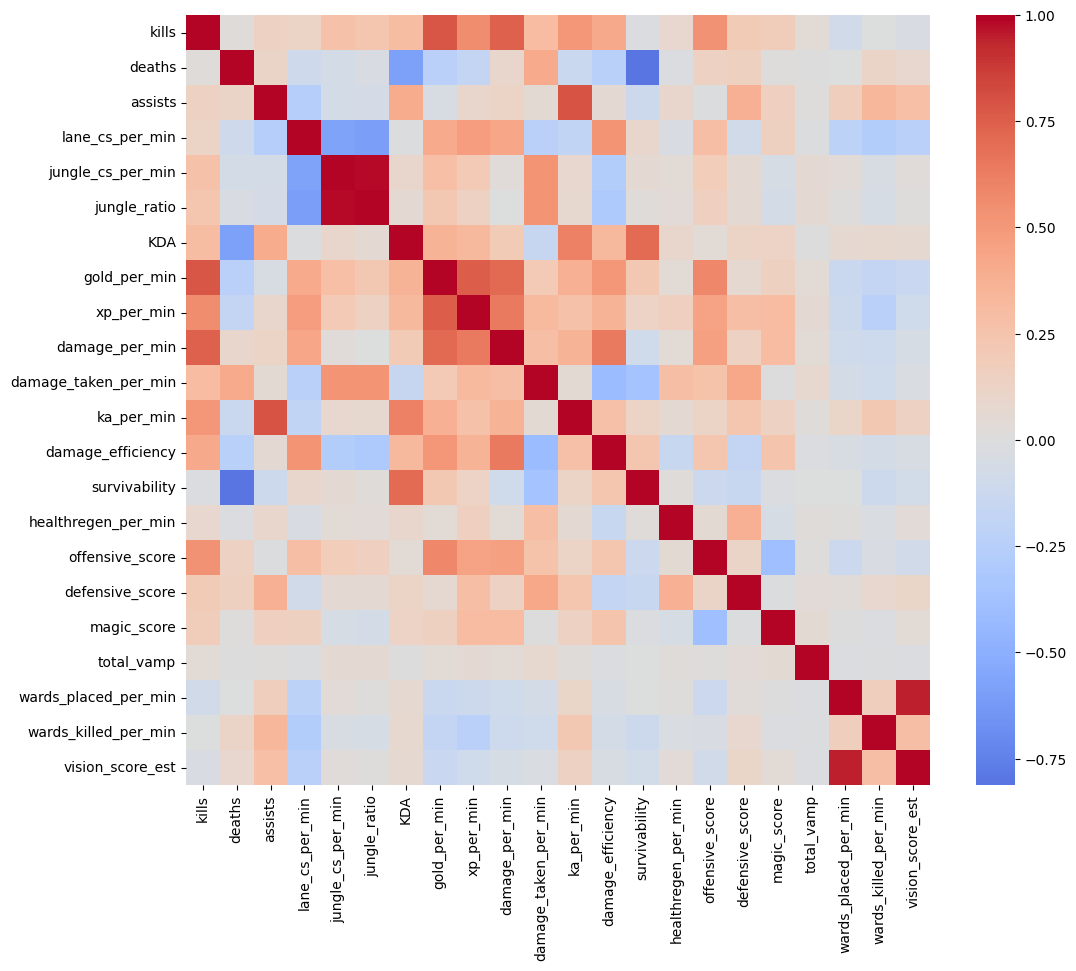

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = filtered_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)

In [151]:
import pandas as pd

# 상관계수 행렬
corr_matrix = filtered_df.corr().abs()

# 자기 자신과의 상관관계는 제외
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각행렬 마스킹
corr_matrix_masked = corr_matrix.mask(mask)

# 기준 이상 (ex: 0.8 이상)인 변수쌍 추출
high_corr_pairs = corr_matrix_masked.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# 0.8 이상인 경우만 필터링
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.7]

# 출력
print(high_corr_pairs)

            Variable1             Variable2  Correlation
14       jungle_ratio     jungle_cs_per_min     0.980574
229  vision_score_est  wards_placed_per_min     0.947711
79      survivability                deaths     0.812137
57         ka_per_min               assists     0.790342
21       gold_per_min                 kills     0.785295
35         xp_per_min          gold_per_min     0.762318
36     damage_per_min                 kills     0.744366
43     damage_per_min          gold_per_min     0.715656
84      survivability                   KDA     0.703254


In [152]:
drop_col = ['jungle_ratio', 'vision_score_est', 'deaths', 'assists', 'kills']
X_top = filtered_df.drop(columns=drop_col)

In [154]:
# 상관계수 행렬
corr_matrix = X_top.corr().abs()

# 자기 자신과의 상관관계는 제외
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각행렬 마스킹
corr_matrix_masked = corr_matrix.mask(mask)

# 기준 이상 (ex: 0.8 이상)인 변수쌍 추출
high_corr_pairs = corr_matrix_masked.stack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

# 0.8 이상인 경우만 필터링
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.8]

# 출력
print(high_corr_pairs)

Empty DataFrame
Columns: [Variable1, Variable2, Correlation]
Index: []


In [156]:
X_top

,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,7.237928,0.122677,10.666667,521.345498,628.779658,1184.965351,1092.589762,0.981414,1.084547,0.333333,286.358193,541,293,0,0,0.276023,0.184015
2,7.115251,0.245353,2.090909,428.693886,550.205202,1149.419765,957.369320,0.705391,1.200602,0.090909,38.673844,383,203,344,0,0.306692,0.153346
5,5.091085,0.490707,1.363636,332.269964,431.638128,572.777724,1153.437428,0.460038,0.496583,0.090909,45.942441,540,308,0,0,0.368030,0.092008
6,2.821565,5.183092,4.555556,544.102034,577.378101,963.135127,1721.737450,1.257437,0.559397,0.111111,53.211038,624,328,0,0,0.092008,0.398699
7,4.907070,0.184015,2.888889,377.322999,458.320320,898.515151,1283.260094,0.797399,0.700182,0.111111,59.559560,430,274,0,0,0.245353,0.214684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,1.338791,0.000000,3.200000,249.221041,287.565380,447.362067,759.712240,0.549247,0.588857,0.200000,37.623452,202,152,90,0,1.338791,0.583575
8855,6.934249,0.000000,2.500000,400.847672,564.969683,736.849814,857.032027,0.514920,0.859769,0.166667,37.348828,287,238,407,0,0.205968,0.102984
8856,0.583575,5.183523,5.250000,464.114115,561.262262,682.131034,1720.586367,0.720887,0.396453,0.250000,43.699502,461,216,44,0,0.308952,0.411936
8857,9.302879,0.274624,4.400000,552.474303,688.722004,1090.839811,743.578096,0.755215,1.467014,0.200000,30.654875,422,246,470,0,0.377608,0.068656


# 유사도 분석
- 일반 유저와 Top1000 유저 간의 유사도를 수치로 계산
- 가장 유사한 상위 10~20명을 추출

## 유사도 계산용 피처 선택
- 유저의 게임 스타일을 구성하는 성능 지표

카테고리 | 예시 지표 | 의미
------ | ------- | ----
성장 | CS/Min, Gold/Min, XP/Min | 파밍 능력
전투 | KDA, KA/Min, Damage | 교전 참여도
생존 | Survivability, Damage Efficiency | 얼마나 잘 살아남는가
능력치 | offensive_score 등 | 스탯 종합
시야 | wards_placed_per_min 등 | 맵 컨트롤 능력

## 정규화 (Standard Scaler)
- 모든 feature는 단위와 크기가 다르기 때문에, 정규화를 하지 않으면 왜곡된 유사도가 계산

### 💡 StandardScaler 작동 방식     
- 평균을 0으로, 표준편차를 1로 바꾸는 방식        
    → 값의 분포가 동일한 기준에서 비교되도록 조정

In [ ]:
from sklearn.preprocessing import StandardScaler

# 일반 유저 하나 선택 (예: puuid 기반)
# target_puuid = df_user['puuid'].sample(1).values[0]
target_puuid = '1nry226Ys8jmA4IrYNRAqBOLA09dO_oisz6Din8AyUOowu80Mp3ggYKg3moP6BbiDD8d8fw9t-3IVw' 
X_target = merged_df[merged_df["puuid"] == target_puuid][features].fillna(0).iloc[0:1]

# 스케일링
scaler = StandardScaler()
scaler.fit(pd.concat([X_top, X_target]))  # 전체 기준으로 학습
X_top_scaled = scaler.transform(X_top)
X_target_scaled = scaler.transform(X_target)


## 유사도 계산 (Cosine Similarity)
- 두 벡터(유저)의 방향이 얼마나 비슷한지를 보는 지표

  - 모든 유저를 동일한 척도로 정규화

  - 기준 유저와 Top 유저 각각의 "플레이 스타일 유사도"를 수치화

  - 이제 정량적 비교가 가능해짐 → 추천, 시각화, 군집화 등 모두 이 위에서 진행됨

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# 유사도 계산
similarities = cosine_similarity(X_target_scaled, X_top_scaled)[0]  # 1행으로 나온 값


## 유사도 상위 유저 추출
- 기준 유저와 각 Top 유저 간의 유사도 배열

In [22]:
# 상위 유저 리스트 가져오기
top_players = merged_df[merged_df["is_top1000"] == True][["puuid", "game_id", "participant_id"]].drop_duplicates()

# 유사도 결과와 합치기
top_players["similarity"] = similarities

# 상위 10명 추출
top_similar_players = top_players.sort_values("similarity", ascending=False).head(10)


In [23]:
# 유사도(similarity)가 높은 상위 유저 10명 추출
print(top_similar_players[["puuid", "game_id", "participant_id", "similarity"]])


                                                  puuid     game_id  \
5908  N8s2Toz0lAW-qfSH3A0NufmmkZeVXQoqKYMDedmESurz6n...  7587157805   
5323  JkAtetPeV8eLH-GNF14_7Z96cIMbONg0x-7yil5ZrhqURu...  7586075765   
1815  _v3N7CJjg-9RvLsJjD-ciWb4ZtXdigRT2miD8SYenA7wnK...  7586550262   
3148  0S7Qb-aNl4ZarGy2KldZFAAN4qum5qqCeGLJDv4vUn-d2V...  7587236000   
4267  znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...  7586830524   
4335  EVMY5lU8NxM93WsfJe1FH5irgp_daSX36OzDqSLmhoycEu...  7587377295   
4541  BMLYrja7g84tXOAYN6an9UVxswRCySLhffkA_x8VKlFi-s...  7586513486   
8122  mkuS-q15u1Xgel-8i20FgzR0qO16_5dV3IdJOiu6rGtQIm...  7587139551   
2616  7UDpSRt0mNr-aRORdAY9-LXLEexD2goynSIcH63l2jRdYg...  7585750368   
6485  Tjx_NecuU07AaxNwLyhT7sOX6kYjLTtSnwteY6g_jrpeya...  7587091839   

      participant_id  similarity  
5908               9    0.960658  
5323               4    0.924943  
1815               6    0.917098  
3148               9    0.912967  
4267               8    0.900781  
4335    

## 데이터 추출

In [24]:
# export_df = top_similar_players[["puuid", "game_id", "participant_id", "similarity"]]

In [25]:
# export_df.to_csv("top_similar_users.csv", index=False)


## 데이터 시각화

### 2차원 좌표 생성 (PCA or t-SNE)
#### 📌 PCA란?
> PCA는 데이터의 가장 큰 **변동성(variance)** 을 유지하면서      
> 고차원 데이터를 저차원으로 압축하는 수학 기법이야.

- 데이터를 선형 조합하여 새로운 축(주성분)을 생성

- 첫 번째 축: 데이터의 가장 큰 분산 방향

- 두 번째 축: 그다음으로 큰 분산 방향 (첫 축과 직교)

단계 | 설명
--- | ---
X_vis | 유사도 상위 10명의 원본 성능 데이터
scaler.transform() | 앞에서 학습된 정규화 모델로 스케일링
pca.fit_transform() | 정규화된 데이터를 2차원으로 압축 (x, y 좌표)

In [26]:
from sklearn.decomposition import PCA

# 해당 유저들만 필터링
similar_puuids = top_similar_players["puuid"].tolist()
X_vis = merged_df[merged_df["puuid"].isin(similar_puuids)][features].fillna(0)

# PCA로 2D 압축
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X_vis))

# 위치 + 메타데이터 결합
plot_df = merged_df[merged_df["puuid"].isin(similar_puuids)].copy()
plot_df = plot_df.reset_index(drop=True)
plot_df["x"] = X_pca[:, 0]
plot_df["y"] = X_pca[:, 1]


In [27]:
# similarity 정보 복원
similarity_map = top_similar_players.set_index("puuid")["similarity"].to_dict()
plot_df["similarity"] = plot_df["puuid"].map(similarity_map)


#### 💡 PCA가 아니라 t-SNE는 안 썼는가?

기법 | 설명 | 장단점
--- | --- | ---
PCA | 선형 변환, 빠름, 해석 가능 | 빠르고 간단, 큰 구조 보기 좋음
t-SNE | 비선형, 국소적 구조 보존 | 군집 표현에 강하지만 느리고 전역 해석 어려움

### matplotlib + interactive 클릭 이벤트 시각화
vscode에서는 matplotlib이 클릭이 작동이 안됌

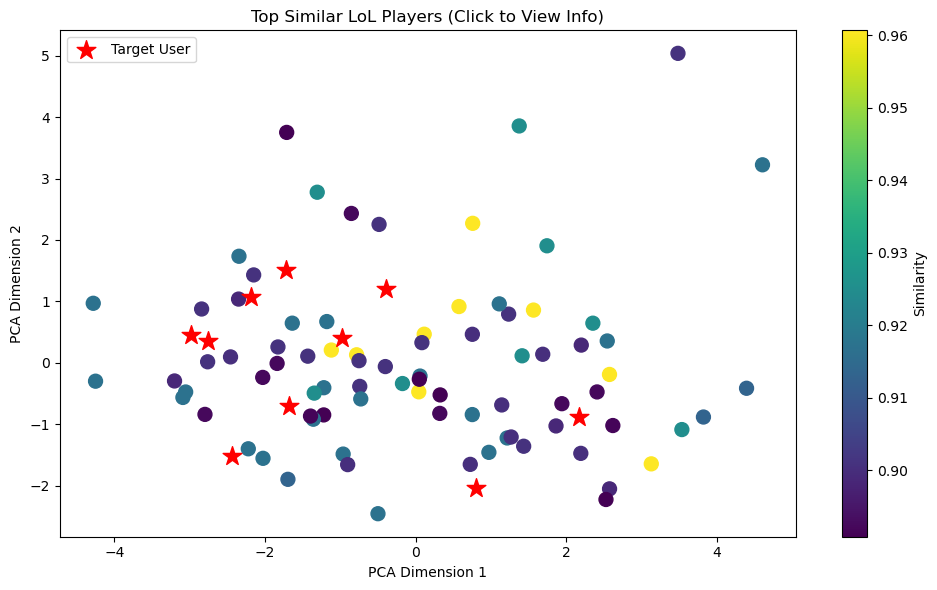

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(plot_df["x"], plot_df["y"], c=plot_df["similarity"], cmap="viridis", s=100)

# 텍스트 박스 준비
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# 클릭 시 작동할 함수 정의
def update_annot(ind):
    i = ind["ind"][0]
    row = plot_df.iloc[i]
    text = f"""PUUID: {row['puuid']}
                KDA: {row['KDA']:.2f}
                CS/Min: {row['cs_per_min']:.2f}
                Gold/Min: {row['gold_per_min']:.2f}
                Damage/Min: {row['damage_per_min']:.2f}
                Vision Score: {row['vision_score_est']}
                Similarity: {row['similarity']:.2f}
            """
    annot.xy = (row["x"], row["y"])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.9)

# 마우스 클릭 이벤트 연결
def on_click(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scatter.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", on_click)

# 기준 유저 좌표(★)
target_row = merged_df[merged_df["puuid"] == target_puuid].copy()
target_scaled = scaler.transform(target_row[features].fillna(0))
target_pca = pca.transform(target_scaled)
ax.scatter(target_pca[:, 0], target_pca[:, 1], c="red", marker="*", s=200, label="Target User")
ax.legend()


plt.title("Top Similar LoL Players (Click to View Info)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar(scatter, label="Similarity")
plt.tight_layout()
plt.show()

### 상대적 거리 좌표 생성 (유사도 → 거리 변환)
기준 유저를 중심으로        
유사도가 높을수록 가까운 거리,      
       낮을수록 멀리 배치

In [29]:
import numpy as np

# 유사도 기반 거리 계산 (0~1 사이 → 가까울수록 유사함)
top_similar_players["distance"] = 1 - top_similar_players["similarity"]

# 간단한 원형 배치: 유사한 순서대로 각도를 나눠서 원 주변에 배치
angles = np.linspace(0, 2 * np.pi, len(top_similar_players), endpoint=False)
top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
top_similar_players["y"] = np.sin(angles) * top_similar_players["distance"]

# 파생 지표 붙이기 (중복 제거 주의!)
top_features = merged_df[["game_id", "participant_id", "KDA", "cs_per_min", "gold_per_min"]].copy()
top_similar_players = pd.merge(
    top_similar_players,
    top_features,
    on=["game_id", "participant_id"],
    how="left"
)

# 기준 유저 좌표 (항상 중심)
target_user_df = pd.DataFrame({
    "puuid": [target_puuid],
    "x": [0.0],
    "y": [0.0],
    "KDA": merged_df.loc[merged_df["puuid"] == target_puuid, "KDA"].values[0],
    "cs_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "cs_per_min"].values[0],
    "gold_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "gold_per_min"].values[0],
    "label": ["Target"]
})

# 상위 유저 + 타겟 유저 병합
top_similar_players["label"] = "Top"
plot_df = pd.concat([top_similar_players, target_user_df], ignore_index=True)


In [30]:
# import plotly.express as px

# # Plotly용 데이터 준비
# fig = px.scatter(
#     plot_df,
#     x="x", y="y",
#     color="similarity",
#     hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
#     text="label",
#     color_continuous_scale="Viridis",
#     title="Similarity-based Positioning (Target User = Center)"
# )

# # 기준 유저 강조 (색 없음, hover로만 표시됨)
# fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))

# fig.show()


### Plotly로 시각화
- 기준 유저와 유사한 Top 유저들을 2D 공간에 배치하고    
   유사도, KDA, CS/분 등의 정보를 마우스만으로 직관적으로 파악
- 색상, 크기, 마커, 텍스트 등 시각 정보를 다차원적으로 표현



In [31]:
# 기준 유저 따로 빨간 점으로 표시
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px

# Plotly용 데이터 준비
fig = px.scatter(
    plot_df,
    x="x", y="y",
    color="similarity",
    # 마우스를 올리면 나오는 정보
    hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
    text="label",
    color_continuous_scale="Viridis",
    title="Similarity-based Positioning (Target User = Center)"
)

# 기준 유저 강조 (색 없음, hover로만 표시됨)
fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))


target_trace = px.scatter(
    target_user_df,
    x="x", y="y",
    hover_data=["KDA", "cs_per_min", "gold_per_min"],
    text=["You"],
)

target_trace.update_traces(marker=dict(size=16, color='red', symbol='star'))
fig.add_trace(target_trace.data[0])


### 일반 유저 + 상위 유저 지표 비교 막대그래프 같이 그리기
- 기준 유저(일반 유저)의 최근 10게임의 KDA 변화를 시각화

- 상위 1000명 유저들의 평균 KDA 선과 비교

- 사용자에게 실력의 흐름 + 상대적 수준을 한눈에 보여주는 것

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas as pd

# # 1. 기준 유저 게임 가져오기
# user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
# user_games = user_games.sort_values("game_id", ascending=False).head(10)

# # 2. KDA 데이터 부족 시 채우기 (0으로)
# kda_values = user_games["KDA"].tolist()
# kda_values += [0] * (10 - len(kda_values))  # 10게임 채우기

# # 2-1 CS 데이터 부족 시 채우기
# cs_values = user_games["cs_per_min"].tolist()
# cs_values += [0] * (10 - len(cs_values))


# # 3. x축 레이블
# x_labels = [f"Game {i+1}" for i in range(10)]

# # 4. Top 평균 KDA
# top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()

# # 4-1. Top 평균 CS
# top_avg_cs = merged_df[merged_df["is_top1000"] == True]["cs_per_min"].mean()


# # # 5. 그래프 생성
# # fig = go.Figure()

# # # 유저 KDA 막대
# # fig.add_trace(go.Bar(
# #     x=x_labels,
# #     y=kda_values,
# #     name="Target User KDA",
# #     marker_color='royalblue'
# # ))

# # # Top 유저 평균 선
# # fig.add_trace(go.Scatter(
# #     x=x_labels,
# #     y=[top_avg_kda] * 10,
# #     name="Top Players Avg KDA",
# #     mode='lines',
# #     line=dict(color='red', dash='dash')
# # ))

# # fig.update_layout(
# #     title="Recent 10 Games KDA vs Top Player Avg KDA",
# #     xaxis_title="Game",
# #     yaxis_title="KDA",
# #     barmode='group',
# #     template='plotly_white'
# # )

# # fig.show()

# # 두 개의 서브플롯 생성 (1행 2열)
# fig = make_subplots(
#     rows=1, cols=2, subplot_titles=("KDA vs Top Avg", "CS per Min vs Top Avg")
# )

# # Target 유저 데이터
# fig.add_trace(
#     go.Bar(x=x_labels, y=kda_values, name="Target User KDA", marker_color="royalblue"),
#     row=1,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_labels,
#         y=[top_avg_kda] * 10,
#         name="Top Players Avg KDA",
#         line=dict(color="red", dash="dash"),
#     ),
#     row=1,
#     col=1,
# )

# fig.add_trace(
#     go.Bar(x=x_labels, y=cs_values, name="Target User CS/Min", marker_color="seagreen"),
#     row=1,
#     col=2,
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_labels,
#         y=[top_avg_cs] * 10,
#         name="Top Players Avg CS/Min",
#         line=dict(color="orange", dash="dash"),
#     ),
#     row=1,
#     col=2,
# )

# # 레이아웃 설정
# fig.update_layout(
#     title_text="Recent 10 Games Comparison: KDA vs CS per Min",
#     template="plotly_white",
#     showlegend=True,
# )

# # 축 레이블 개별 설정
# fig.update_xaxes(title_text="Game", row=1, col=1)
# fig.update_yaxes(title_text="KDA", row=1, col=1)

# fig.update_xaxes(title_text="Game", row=1, col=2)
# fig.update_yaxes(title_text="CS per Min", row=1, col=2)

# fig.show()

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 경기 10개, x축 라벨
x_labels = [f"Game {i+1}" for i in range(10)]

# 데이터 준비
user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
user_games = user_games.sort_values("game_id", ascending=False).head(10)


def fill_10(values):
    return values.tolist() + [0] * (10 - len(values))


kda_values = fill_10(user_games["KDA"])
cs_values = fill_10(user_games["cs_per_min"])
gold_values = fill_10(user_games["gold_per_min"])
damage_values = fill_10(user_games["damage_per_min"])

# 상위 유저 평균값
top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()
top_avg_cs = merged_df[merged_df["is_top1000"] == True]["cs_per_min"].mean()
top_avg_gold = merged_df[merged_df["is_top1000"] == True]["gold_per_min"].mean()
top_avg_damage = merged_df[merged_df["is_top1000"] == True]["damage_per_min"].mean()

# subplot 구성
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "KDA vs Top Avg",
        "CS per Min vs Top Avg",
        "Gold per Min vs Top Avg",
        "Damage per Min vs Top Avg",
    ),
)

# (1,1) KDA
fig.add_trace(
    go.Bar(x=x_labels, y=kda_values, name="KDA", marker_color="royalblue"), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_kda] * 10,
        name="Top Avg KDA",
        line=dict(color="red", dash="dash"),
    ),
    row=1,
    col=1,
)

# (1,2) CS/Min
fig.add_trace(
    go.Bar(x=x_labels, y=cs_values, name="CS/Min", marker_color="seagreen"),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_cs] * 10,
        name="Top Avg CS",
        line=dict(color="orange", dash="dash"),
    ),
    row=1,
    col=2,
)

# (2,1) Gold/Min
fig.add_trace(
    go.Bar(x=x_labels, y=gold_values, name="Gold/Min", marker_color="goldenrod"),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_gold] * 10,
        name="Top Avg Gold",
        line=dict(color="darkblue", dash="dash"),
    ),
    row=2,
    col=1,
)

# (2,2) Damage/Min
fig.add_trace(
    go.Bar(x=x_labels, y=damage_values, name="Damage/Min", marker_color="indianred"),
    row=2,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_damage] * 10,
        name="Top Avg Damage",
        line=dict(color="black", dash="dash"),
    ),
    row=2,
    col=2,
)

# 전체 레이아웃 설정
fig.update_layout(
    title_text="Recent 10 Games Comparison (KDA / CS / Gold / Damage)",
    template="plotly_white",
    height=800,
    showlegend=False,
)

# 개별 축 설정
fig.update_xaxes(title_text="Game", row=1, col=1)
fig.update_yaxes(title_text="KDA", row=1, col=1)

fig.update_xaxes(title_text="Game", row=1, col=2)
fig.update_yaxes(title_text="CS/Min", row=1, col=2)

fig.update_xaxes(title_text="Game", row=2, col=1)
fig.update_yaxes(title_text="Gold/Min", row=2, col=1)

fig.update_xaxes(title_text="Game", row=2, col=2)
fig.update_yaxes(title_text="Damage/Min", row=2, col=2)

fig.show()

### 유사도 순 정렬된 테이블 만들기

In [33]:
import pandas as pd
from IPython.display import display

display(
    plot_df[plot_df["label"] == "Top"]
    .sort_values("similarity", ascending=False)[
        ["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"]
    ]
)


,puuid,KDA,cs_per_min,gold_per_min,similarity
0,N8s2Toz0lAW-qfSH3A0NufmmkZeVXQoqKYMDedmESurz6n...,3.333333,8.574889,517.611504,0.960658
1,JkAtetPeV8eLH-GNF14_7Z96cIMbONg0x-7yil5ZrhqURu...,5.166667,8.571203,519.099380,0.924943
2,_v3N7CJjg-9RvLsJjD-ciWb4ZtXdigRT2miD8SYenA7wnK...,3.666667,6.632733,471.255647,0.917098
3,0S7Qb-aNl4ZarGy2KldZFAAN4qum5qqCeGLJDv4vUn-d2V...,10.000000,6.606017,591.492586,0.912967
4,znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...,1.600000,8.204457,472.212077,0.900781
5,EVMY5lU8NxM93WsfJe1FH5irgp_daSX36OzDqSLmhoycEu...,3.400000,8.544045,474.748594,0.900137
6,BMLYrja7g84tXOAYN6an9UVxswRCySLhffkA_x8VKlFi-s...,3.750000,7.966532,496.677442,0.898521
7,mkuS-q15u1Xgel-8i20FgzR0qO16_5dV3IdJOiu6rGtQIm...,4.400000,8.686750,496.346472,0.892245
8,7UDpSRt0mNr-aRORdAY9-LXLEexD2goynSIcH63l2jRdYg...,7.250000,7.296867,525.751860,0.891860
9,Tjx_NecuU07AaxNwLyhT7sOX6kYjLTtSnwteY6g_jrpeya...,3.166667,9.751682,525.973625,0.890804
